In [170]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [171]:
seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

In [172]:
X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]

In [173]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

(8000, 100)
(1000, 100)
(1000, 100)
(8000,)
(8000,)
(1000,)
(1000,)
(1000,)
(1000,)


In [174]:
X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

In [175]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

torch.Size([8000, 100])
torch.Size([1000, 100])
torch.Size([1000, 100])
torch.Size([8000])
torch.Size([8000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [176]:
input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []

In [177]:
class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

In [178]:
def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [179]:
Weightloss1 = torch.FloatTensor([1]).clone().detach().requires_grad_(True)
Weightloss2 = torch.FloatTensor([1]).clone().detach().requires_grad_(True)

params = [Weightloss1, Weightloss2]
MTL = MTLnet()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
opt2 = torch.optim.Adam(params, lr=LR)
loss_func = nn.MSELoss(reduction='mean')
Gradloss = nn.L1Loss()

In [180]:
alph = 0.15
sse = []

msetr = []
mse1tr = []
mse2tr = []

lgradLoss = []

mse1 = []
mse2 = []
rmse = []

weights1 = []
weights2 = []
weights1tr = []
weights2tr = []
r2_tr1 = []
r2_tr2 = []
r2_D1 = []
r2_D2 = []
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    num_minibatches = int(input_size / mb_size) 
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size)
    for minibatch in minibatches:
        MTL.train()
        XE, YE1, YE2  = minibatch 
        
        Yhat1, Yhat2 = MTL(XE)
        l1 = params[0]*loss_func(Yhat1, YE1.view(-1,1))    
        l2 = params[1]*loss_func(Yhat2, YE2.view(-1,1))
        loss = torch.div(torch.add(l1,l2), 2)

        # for the first epoch with no l0
        if it == 0:
            l01 = l1.data  
            l02 = l2.data
        
        opt1.zero_grad()
        
        loss.backward(retain_graph=True)   
        
        param = list(MTL.parameters())
        
        # Getting gradients of the first layers of each tower and calculate their l2-norm 
        G1R = torch.autograd.grad(l1, param[0], retain_graph=True, create_graph=True)
        G1 = torch.norm(G1R[0], 2)
        G2R = torch.autograd.grad(l2, param[0], retain_graph=True, create_graph=True)
        G2 = torch.norm(G2R[0], 2) 

        # l2-norm of the average gradient of the two towers
        G_avg = torch.div(torch.add(G1, G2), 2) 
        
        # Calculating relative losses 
        lhat1 = torch.div(l1,l01)
        lhat2 = torch.div(l2,l02)
        lhat_avg = torch.div(torch.add(lhat1, lhat2), 2)
        
        # Calculating relative inverse training rates for tasks 
        inv_rate1 = torch.div(lhat1,lhat_avg)
        inv_rate2 = torch.div(lhat2,lhat_avg)
        
        # Calculating the constant target for Eq. 1 in the GradNorm paper
        C1 = G_avg*(inv_rate1)**alph
        C2 = G_avg*(inv_rate2)**alph
        C1 = C1.detach()
        C2 = C2.detach()
        
        opt2.zero_grad()
        # Calculating the gradient loss according to Eq. 2 in the GradNorm paper
        Lgrad = torch.add(Gradloss(G1, C1),Gradloss(G2, C2))
        Lgrad.backward()
        
        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Re-normalizing the losses weights
        coef = 2/torch.add(Weightloss1, Weightloss2)
        params = [coef*Weightloss1, coef*Weightloss2]

        # Calculating the mean cost of the epochs and the cost of epoch per tower
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)
        
    weights1tr.append(Weightloss1.item())
    weights2tr.append(Weightloss2.item())
        
    # AVG Cost of Tower 1 and Tower 2
    cost1tr.append(torch.mean(epoch_cost1).detach().numpy())
    cost2tr.append(torch.mean(epoch_cost2).detach().numpy())
    costtr.append(torch.mean(epoch_cost).detach().numpy())

    # MSE of Task 1 and Task 2
    mse1tr_i = mean_squared_error(y_true=torch.detach(Yhat1).numpy() , y_pred=torch.detach(YE1).numpy(), squared=True) 
    mse2tr_i = mean_squared_error(y_true=torch.detach(Yhat2).numpy() , y_pred=torch.detach(YE2).numpy(), squared=True)

    # mean MSE of Task 1 and Task 2
    msetr.append(np.divide(np.add(mse1tr_i, mse2tr_i), 2))
    mse1tr.append(mse1tr_i)
    mse2tr.append(mse2tr_i)
    
    with torch.no_grad():
        MTL.eval()
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = params[0]*loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = params[1]*loss_func(Yhat2D, Y2_valid.view(-1,1))

        r2_D1.append(r2_score(y_true=torch.detach(Y1_valid).numpy(), y_pred=torch.detach(Yhat1D).numpy()))
        r2_D2.append(r2_score(y_true=torch.detach(Y2_valid).numpy(), y_pred=torch.detach(Yhat2D).numpy()))

        # wMSE of Task 1
        cost1D.append(l1D)
        # wMSE of Task 2
        cost2D.append(l2D)

        # getting the avg of wMSE of Task 1 and Task 2
        evalLoss = torch.div(torch.add(l1D,l2D),2)
        costD.append(evalLoss)

        # loss is the mean of L1 and L2 training losses
        mse1.append(mean_squared_error(y_true=Yhat1D , y_pred=Y1_valid, squared=True))
        mse2.append(mean_squared_error(y_true=Yhat2D , y_pred=Y2_valid, squared=True))
        rmse.append(np.divide(np.add(mse1, mse2), 2))
        lgradLoss.append(Lgrad.item())
        
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))
        print('Iter-{}; Gradient loss: {:.4}'.format(it, Lgrad.item()))

Iter-0; MTL loss: 0.7183
Iter-0; Gradient loss: 0.05105
Iter-1; MTL loss: 0.5744
Iter-1; Gradient loss: 0.0009593
Iter-2; MTL loss: 0.3677
Iter-2; Gradient loss: 0.002474
Iter-3; MTL loss: 0.3336
Iter-3; Gradient loss: 0.005537
Iter-4; MTL loss: 0.3129
Iter-4; Gradient loss: 0.1328
Iter-5; MTL loss: 0.2971
Iter-5; Gradient loss: 0.04492
Iter-6; MTL loss: 0.2609
Iter-6; Gradient loss: 0.07167
Iter-7; MTL loss: 0.2808
Iter-7; Gradient loss: 0.01648
Iter-8; MTL loss: 0.2284
Iter-8; Gradient loss: 0.05533
Iter-9; MTL loss: 0.2772
Iter-9; Gradient loss: 0.05155
Iter-10; MTL loss: 0.2403
Iter-10; Gradient loss: 0.04235
Iter-11; MTL loss: 0.2371
Iter-11; Gradient loss: 0.1008
Iter-12; MTL loss: 0.2299
Iter-12; Gradient loss: 0.01717
Iter-13; MTL loss: 0.2096
Iter-13; Gradient loss: 0.01656
Iter-14; MTL loss: 0.2101
Iter-14; Gradient loss: 0.02129
Iter-15; MTL loss: 0.1872
Iter-15; Gradient loss: 0.04183
Iter-16; MTL loss: 0.1934
Iter-16; Gradient loss: 0.03536
Iter-17; MTL loss: 0.2253
Iter-1

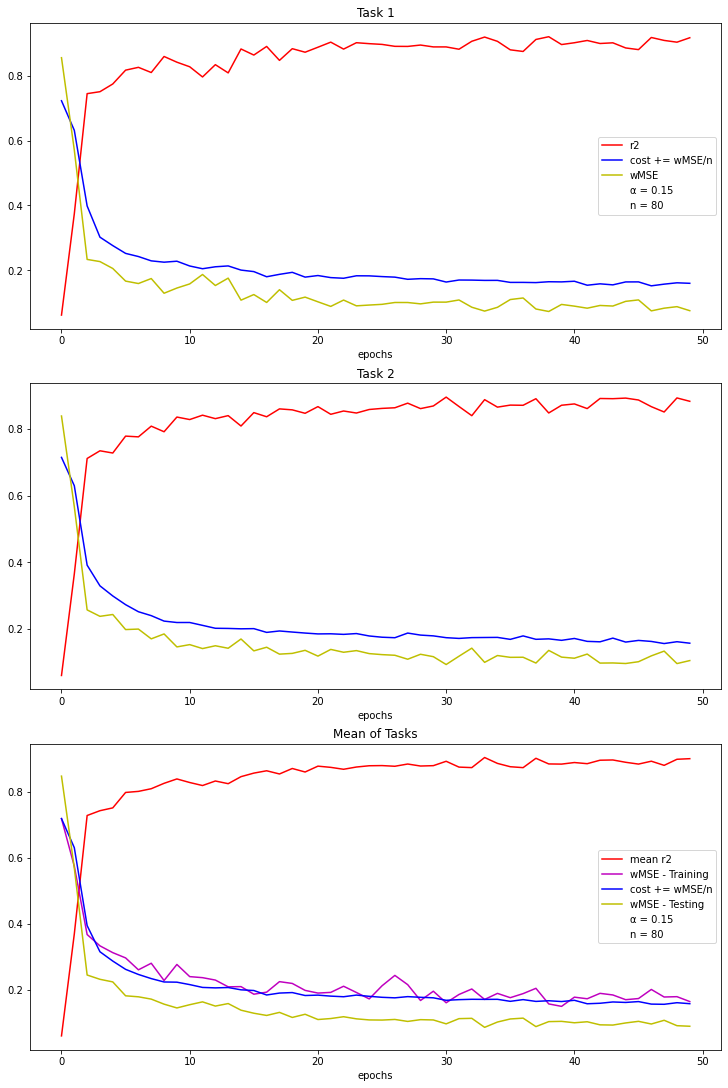

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,15), constrained_layout=True)

# fig.suptitle('SSE vs. Mean Cost vs. Weighted MSE', fontsize=18)

ax1.plot(r2_D1, '-r', np.squeeze(cost1tr), '-b', np.squeeze(cost1D), '-y',  [], '-w', [], '-w')
ax1.title.set_text('Task 1')
ax1.set_xlabel('epochs')
ax1.legend(['r2', 'cost += wMSE/n', "wMSE", 'α = 0.15', 'n = 80',])

ax2.plot(r2_D2, '-r', np.squeeze(cost2tr), '-b', np.squeeze(cost2D), '-y',  [], '-w', [], '-w')
ax2.title.set_text('Task 2')
ax2.set_xlabel('epochs')
# ax2.legend(['r2', 'RMSE', 'cost += wMSE/n', "wMSE", 'α = 0.15', 'n = 80',])

r2_mean = np.divide(np.add(r2_D1, r2_D2),2)
ax3.plot(r2_mean, '-r', msetr, '-m', np.squeeze(costtr), '-b', np.squeeze(costD), '-y', [], '-w', [], '-w')
ax3.title.set_text('Mean of Tasks')
ax3.set_xlabel('epochs')
ax3.legend(['mean r2', 'wMSE - Training', 'cost += wMSE/n', "wMSE - Testing", 'α = 0.15', 'n = 80',])

fig.savefig('./img/sse_tower1and2.png', facecolor='white', transparent=False) 
plt.show()

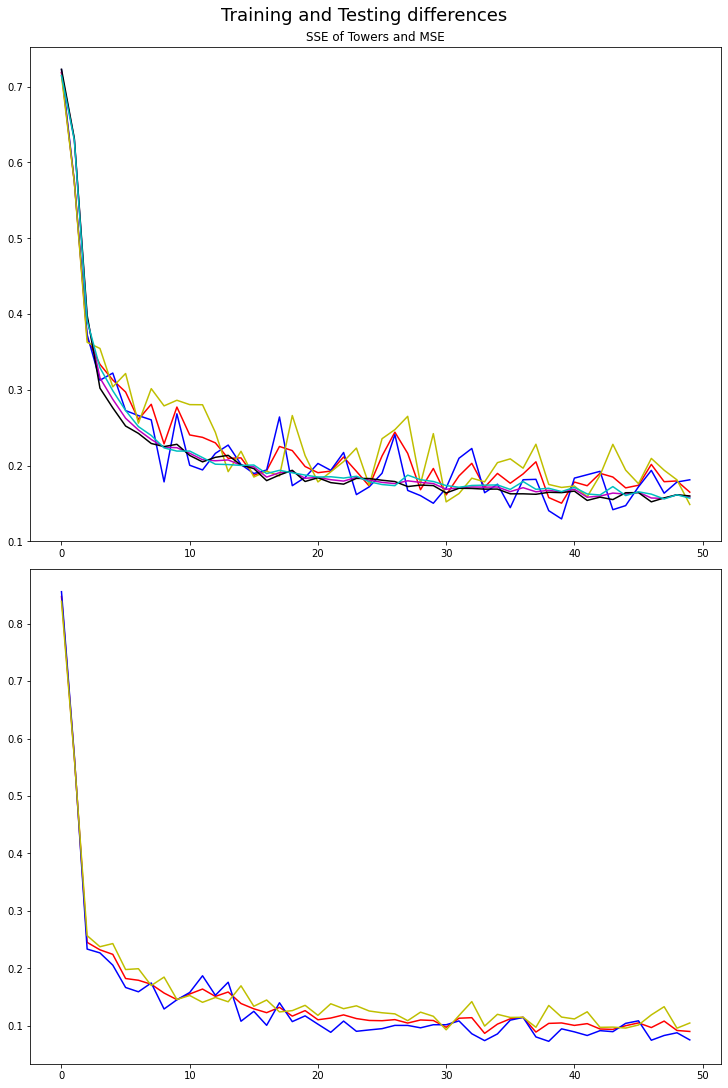

In [182]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,15), constrained_layout=True)

fig.suptitle('Training and Testing differences', fontsize=18)

ax1.plot(msetr, '-r', mse1tr, '-b', mse2tr, '-y',  np.squeeze(costtr), '-m', np.squeeze(cost1tr), '-k', np.squeeze(cost2tr), '-c')
ax1.title.set_text('SSE of Towers and MSE')

ax2.plot(np.squeeze(costD), '-r', np.squeeze(cost1D), '-b', np.squeeze(cost2D), '-y', [], '-w', [], '-w')
ax3.title.set_text('Tower 2 Cost')

plt.show()

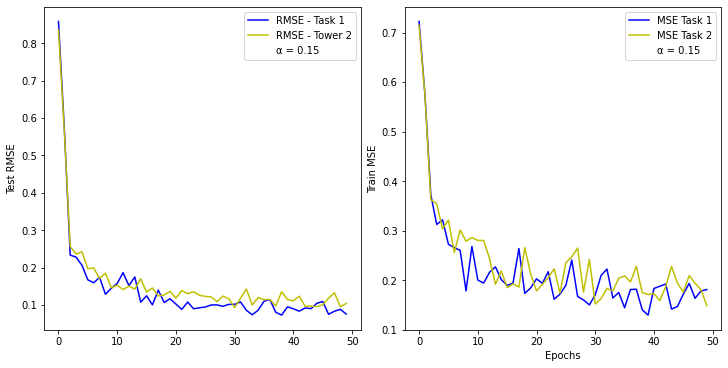

In [183]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)

ax1.plot(mse1, '-b', mse2, '-y', [], '-w')
ax1.legend(['RMSE - Task 1', 'RMSE - Tower 2', 'α = 0.15'])
ax1.set_ylabel('Test RMSE')

ax2.plot(mse1tr, '-b', mse2tr, '-y', [], '-w')
ax2.legend(['MSE Task 1', 'MSE Task 2', 'α = 0.15'])
ax2.set_ylabel('Train MSE')

fig.savefig('./img/rmse_D.png', facecolor='white', transparent=False)
plt.xlabel('Epochs')
plt.show()

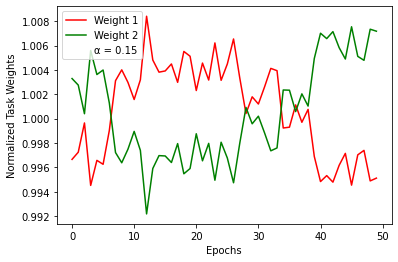

In [185]:
plt.plot(weights1tr, '-r', weights2tr, '-g', [], '-w')
plt.legend(['Weight 1', 'Weight 2', 'α = 0.15'])
plt.savefig('./img/weights_1and2.png', facecolor='white', transparent=False)
plt.ylabel('Normalized Task Weights')
plt.xlabel('Epochs')
plt.show()

In [186]:
# plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD),'-b', rmse, '-y', [], '-w')
# plt.ylabel('total cost')
# plt.xlabel('iterations')
# plt.legend(['mean cost of training', 'mean cost of testing', 'RMSE', 'α = 0.16'])
# plt.savefig('./img/costtr-costD.png', facecolor='white', transparent=False) 
# plt.show()

# plt.plot(np.squeeze(cost1tr),'-r', np.squeeze(cost1D), '-b', mse1, '-y', [], '-w')
# plt.ylabel('task 1 cost')
# plt.xlabel('iterations')
# plt.legend(['cost of training', 'cost of task 1 training', 'SSE', 'α = 0.16'])
# plt.savefig('./img/cost1tr-cost1D.png', facecolor='white', transparent=False)  
# plt.show()

# plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b', mse2, '-y', [], '-w')
# plt.ylabel('task 2 cost')
# plt.xlabel('iterations')
# plt.legend(['cost of training', 'cost of task 2 training', 'SSE', 'α = 0.16'])
# plt.savefig('./img/cost2tr-cost2D.png', facecolor='white', transparent=False) 
# plt.show()